<a href="https://colab.research.google.com/github/Chindyputrii/Optimizing-CNN-for-Cuisine-Image-Recognition/blob/main/Optimizing_CNN_for_Cuisine_Image_Recognition_with_Adam_Optimizer_and_Dropout_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import cv2

# from tensorflow.keras.layers import preprocessing
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers import Rescaling, Normalization, RandomRotation, RandomZoom, RandomFlip


# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2025-01-21 02:01:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-21 02:01:20 (127 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
dataset = "/content/drive/MyDrive/PDM/dataset_padang"
walk_through_dir(dataset)

There are 9 directories and 0 images in '/content/drive/MyDrive/PDM/dataset_padang'.
There are 0 directories and 116 images in '/content/drive/MyDrive/PDM/dataset_padang/telur_dadar'.
There are 0 directories and 111 images in '/content/drive/MyDrive/PDM/dataset_padang/telur_balado'.
There are 0 directories and 104 images in '/content/drive/MyDrive/PDM/dataset_padang/daging_rendang'.
There are 0 directories and 107 images in '/content/drive/MyDrive/PDM/dataset_padang/ayam_goreng'.
There are 0 directories and 119 images in '/content/drive/MyDrive/PDM/dataset_padang/gulai_tunjang'.
There are 0 directories and 109 images in '/content/drive/MyDrive/PDM/dataset_padang/dendeng_batokok'.
There are 0 directories and 113 images in '/content/drive/MyDrive/PDM/dataset_padang/ayam_pop'.
There are 0 directories and 111 images in '/content/drive/MyDrive/PDM/dataset_padang/gulai_ikan'.
There are 0 directories and 103 images in '/content/drive/MyDrive/PDM/dataset_padang/gulai_tambusu'.


In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

Filepath          Label
0    /content/drive/MyDrive/PDM/dataset_padang/telu...    telur_dadar
1    /content/drive/MyDrive/PDM/dataset_padang/telu...    telur_dadar
2    /content/drive/MyDrive/PDM/dataset_padang/telu...    telur_dadar
3    /content/drive/MyDrive/PDM/dataset_padang/telu...    telur_dadar
4    /content/drive/MyDrive/PDM/dataset_padang/telu...   telur_balado
..                                                 ...            ...
989  /content/drive/MyDrive/PDM/dataset_padang/gula...  gulai_tambusu
990  /content/drive/MyDrive/PDM/dataset_padang/gula...  gulai_tambusu
991  /content/drive/MyDrive/PDM/dataset_padang/gula...  gulai_tambusu
992  /content/drive/MyDrive/PDM/dataset_padang/ayam...    ayam_goreng
993  /content/drive/MyDrive/PDM/dataset_padang/ayam...    ayam_goreng

[994 rows x 2 columns]

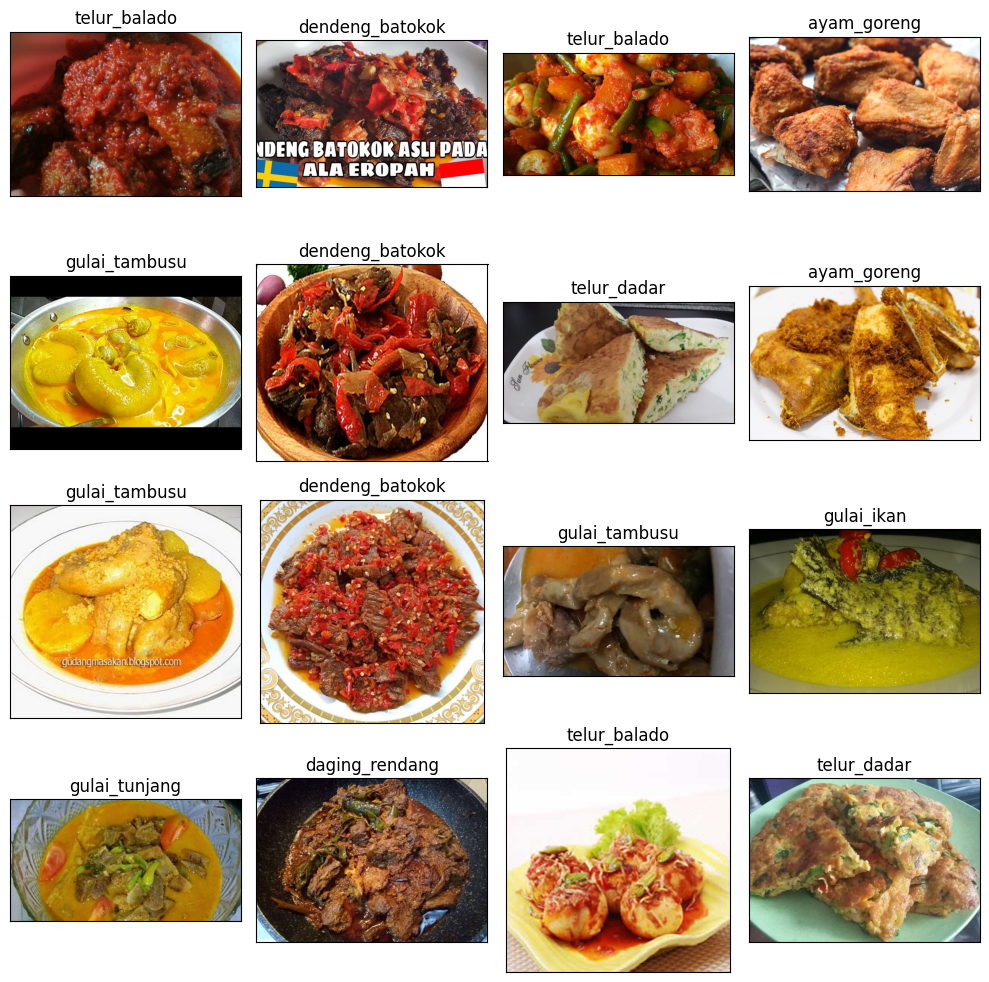

In [ ]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

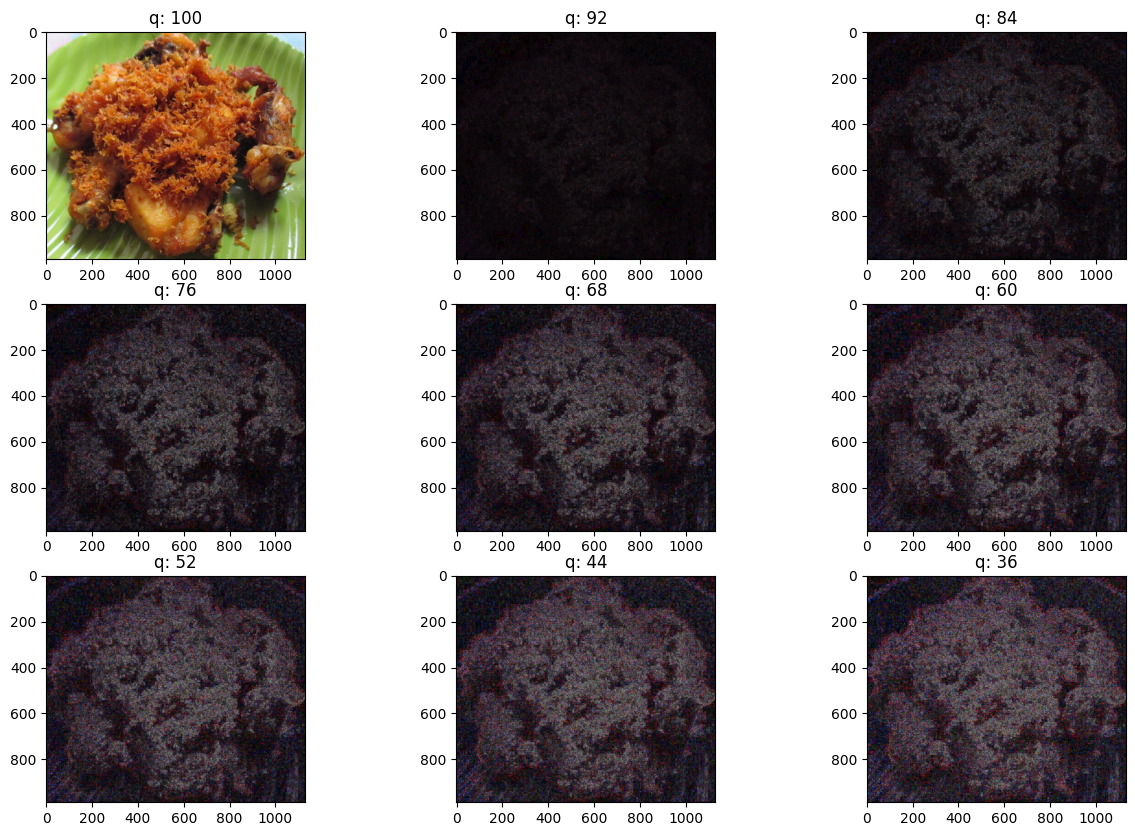

In [ ]:
# View random sample from the dataset
p = random_sample('/content/drive/MyDrive/PDM/dataset_padang/ayam_goreng')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [ ]:
#from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
base_dir = '/content/drive/MyDrive/PDM/dataset_padang'  # Sesuaikan dengan lokasi dataset di Google Drive

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32, #32
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32, #32
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='validation'
)


Found 799 images belonging to 9 classes.
Found 194 images belonging to 9 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
def create_model():
  model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        # BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        # BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        # BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(512, (3, 3), activation='relu'),
        # BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation='relu'),
        # BatchNormalization(),
        Dropout(0.2),
        Dense(9, activation='softmax')   # 9 kategori
  ])
  return model

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
# Kompilasi dan latih model dengan berbagai optimizer
optimizers = {
    'Adam': Adam(),
    'RMSprop': RMSprop(),
    'SGD': SGD()
}



In [ ]:

history = {}

for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name} optimizer...")
    model = create_model()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history[opt_name] = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=100,
        callbacks=reduce_lr,
        verbose=1
    )


Training with Adam optimizer...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.1011 - loss: 3.8591 - val_accuracy: 0.1237 - val_loss: 2.1937 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 495ms/step - accuracy: 0.1281 - loss: 2.1628 - val_accuracy: 0.2990 - val_loss: 1.9208 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 498ms/step - accuracy: 0.2778 - loss: 1.8814 - val_accuracy: 0.3247 - val_loss: 1.9725 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 498ms/step - accuracy: 0.2931 - loss: 1.8200 - val_accuracy: 0.3144 - val_loss: 1.7805 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 493ms/step - accuracy: 0.3255 - loss: 1.7172 - val_accuracy: 0.4124 - val_loss: 1.4714 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 499ms/step - accuracy: 0.3916 - loss: 1.5500 - val_accuracy: 0.4278 - val_loss: 1.5125 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 497ms/step - accuracy: 0.4172 - loss: 1.4579 - v

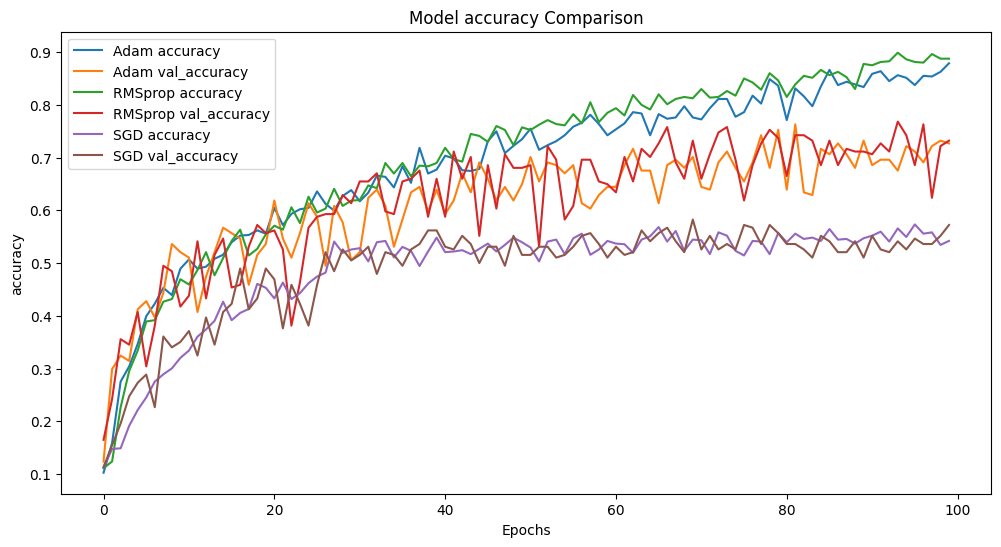

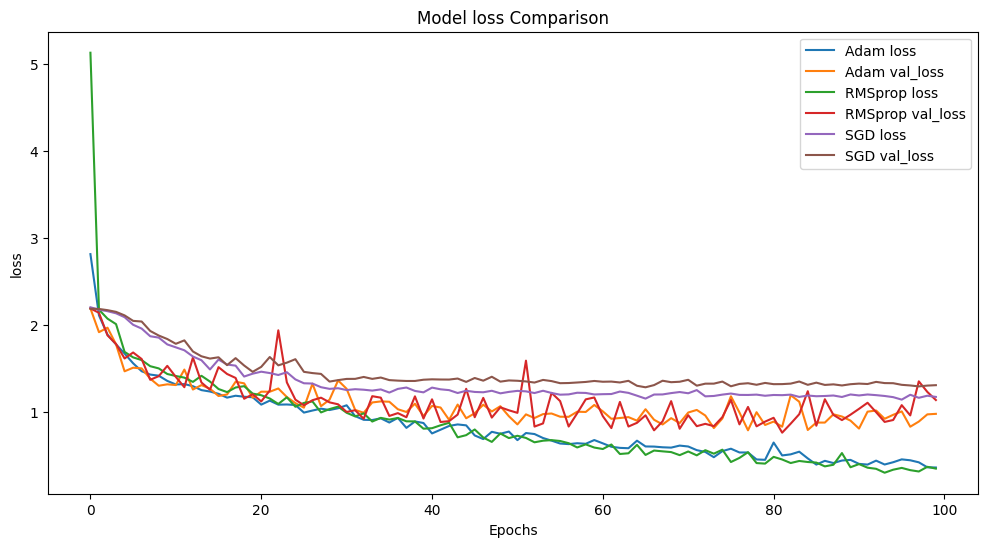

In [ ]:
def plot_history(histories, metric='accuracy'):
    plt.figure(figsize=(12, 6))

    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'{name} val_{metric}')

    plt.title(f'Model {metric} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_history(history, 'accuracy')
plot_history(history, 'loss')


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


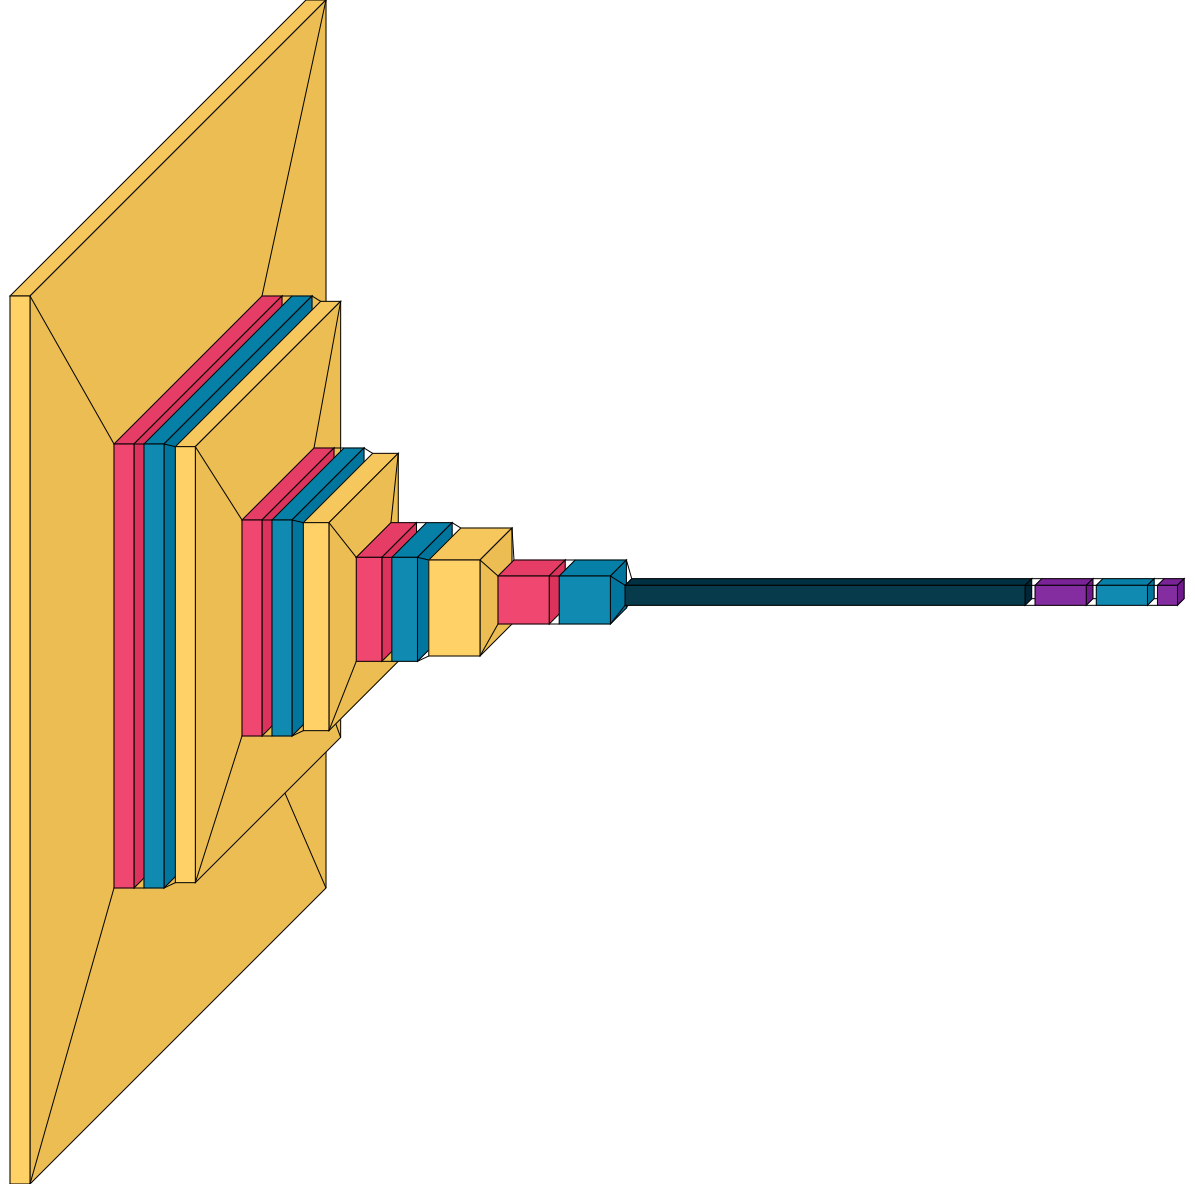

In [ ]:
!pip install visualkeras
import visualkeras
# Plot arsitektur model
visualkeras.layered_view(model)

In [ ]:
pip install pydot graphviz


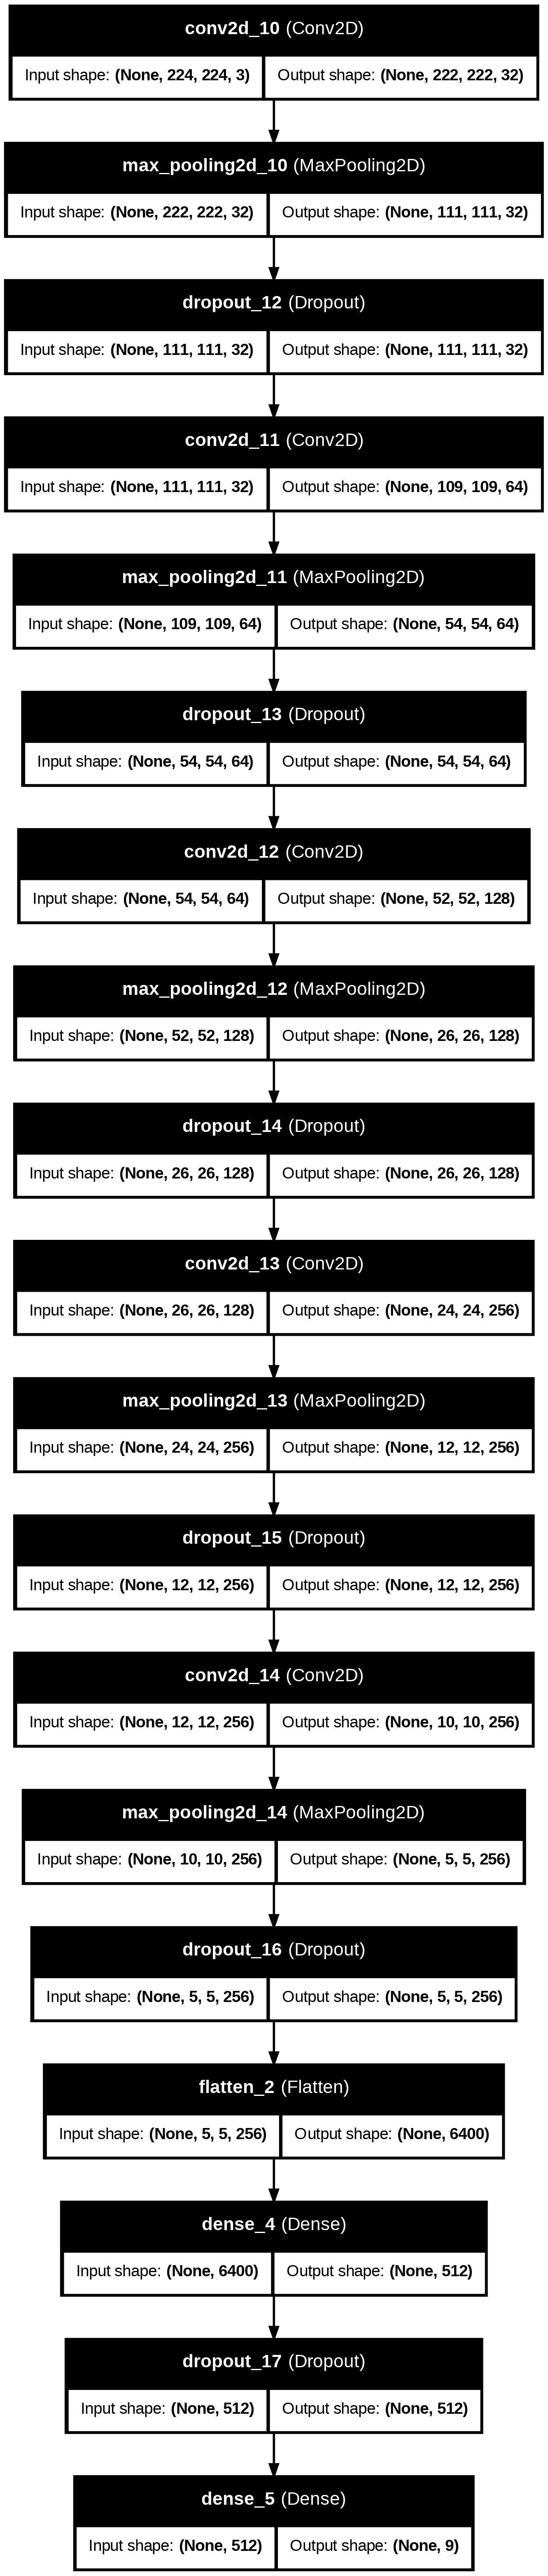

In [ ]:
from tensorflow.keras.utils import plot_model

# Model creation (misalnya model VGG16 atau model Anda yang lain)
model = model  # Ganti dengan model Anda

# Plot model dan simpan ke file .png
plot_model(
    model,
    to_file='model_visualization.png',
    show_shapes=True,  # Menampilkan dimensi input/output layer
    show_layer_names=True  # Menampilkan nama layer
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 13.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


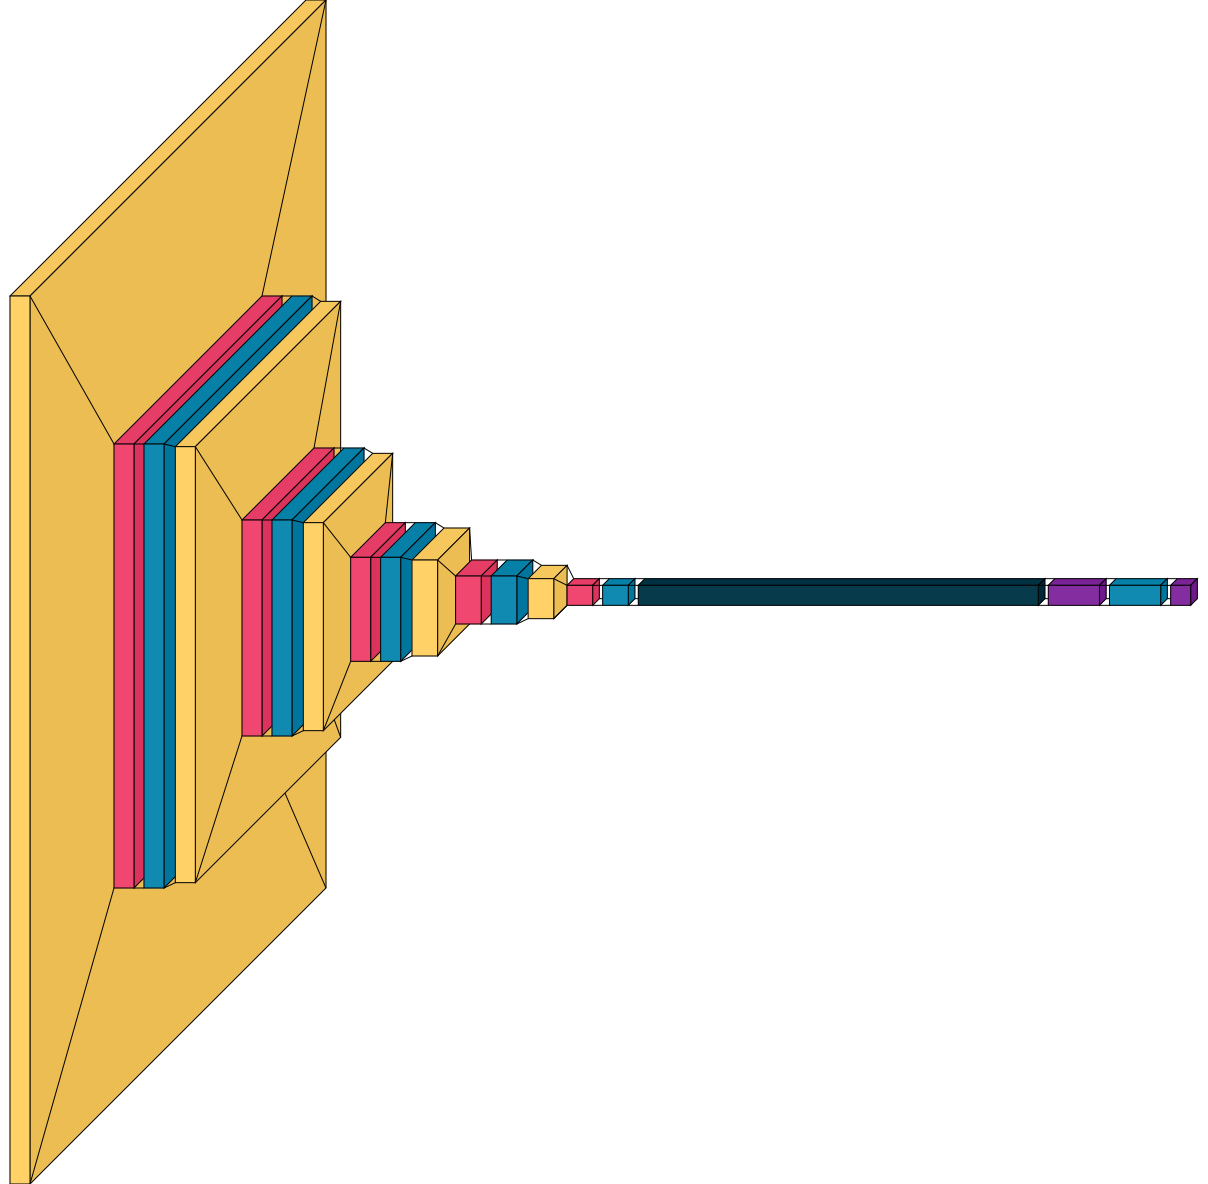

In [ ]:
!pip install visualkeras
import visualkeras
# Plot arsitektur model
visualkeras.layered_view(model)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
def create_model():
  model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(9, activation='softmax')   # 9 kategori
  ])
  return model

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
# Kompilasi dan latih model dengan berbagai optimizer
optimizers = {
    'Adam': Adam(),
    'RMSprop': RMSprop(),
    'SGD': SGD()
}



In [ ]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 72, 72, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 34, 34, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 73984)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │      18,940,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,626,580 (147.35 MB)

 Trainable params: 19,313,289 (73.67 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,313,291 (73.67 MB)

### B2

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
def create_model():
  model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(9, activation='softmax')   # 9 kategori
  ])
  return model
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
# Kompilasi dan latih model dengan berbagai optimizer
optimizers = {
    'Adam': Adam(),
    'Adagrad': Adagrad(),
    'SGD': SGD()
}


In [ ]:
# Create the model instance first
model = create_model()

# Now you can call summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      37,749,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,567,433 (147.12 MB)

 Trainable params: 38,567,433 (147.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = {}

for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name} optimizer...")
    model = create_model()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history[opt_name] = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=150,
        # callbacks=reduce_lr,
        verbose=1
    )


Training with Adam optimizer...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1410 - loss: 4.0581

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 349s 11s/step - accuracy: 0.1405 - loss: 4.0138 - val_accuracy: 0.1856 - val_loss: 2.1949
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 619ms/step - accuracy: 0.1283 - loss: 2.1539 - val_accuracy: 0.2062 - val_loss: 1.8998
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 741ms/step - accuracy: 0.2198 - loss: 1.9296 - val_accuracy: 0.2165 - val_loss: 1.9459
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.2499 - loss: 1.8182 - val_accuracy: 0.2474 - val_loss: 1.7957
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 647ms/step - accuracy: 0.2693 - loss: 1.7497 - val_accuracy: 0.2629 - val_loss: 1.7538
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 627ms/step - accuracy: 0.3652 - loss: 1.5801 - val_accuracy: 0.4227 - val_loss: 1.5481
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 630ms/step - accuracy: 0.4102 - loss: 1.5271 - val_accuracy: 0.4536 - val_loss: 1.4571
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 616ms/step - accuracy: 0.4661 - loss: 1.4233 - val_accuracy:

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
def create_model():
  model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(9, activation='softmax')   # 9 kategori
  ])
  return model
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
# Kompilasi dan latih model dengan berbagai optimizer
optimizers = {
    'Adam': Adam(),
    'Adagrad': Adagrad(),
    'SGD': SGD()
}
history = {}

for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name} optimizer...")
    model = create_model()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history[opt_name] = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=150,
        # callbacks=reduce_lr,
        verbose=1
    )


Training with Adam optimizer...
Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 811ms/step - accuracy: 0.1203 - loss: 4.1772 - val_accuracy: 0.1134 - val_loss: 2.1973
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 622ms/step - accuracy: 0.1218 - loss: 2.1953 - val_accuracy: 0.1186 - val_loss: 2.1811
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 616ms/step - accuracy: 0.1758 - loss: 2.1021 - val_accuracy: 0.1753 - val_loss: 2.0538
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 607ms/step - accuracy: 0.2409 - loss: 1.9825 - val_accuracy: 0.2629 - val_loss: 1.8316
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 614ms/step - accuracy: 0.2945 - loss: 1.8433 - val_accuracy: 0.3196 - val_loss: 1.7902
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 607ms/step - accuracy: 0.3375 - loss: 1.7520 - val_accuracy: 0.4021 - val_loss: 1.5899
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 619ms/step - accuracy: 0.3575 - loss: 1.6061 - val_accuracy: 0.3969 - val_loss: 1.5468
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 736ms/step - a

In [ ]:
    # Save the model after training
    model_save_path = os.path.join(save_dir, f'model_{opt_name}.h5')
    model.save(model_save_path)
    print(f"Model trained with {opt_name} saved to {model_save_path}")

Model trained with SGD saved to models/model_SGD.h5


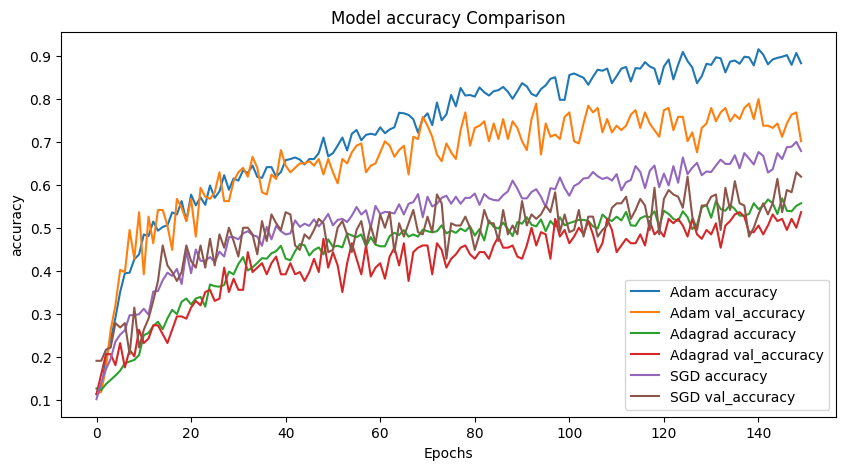

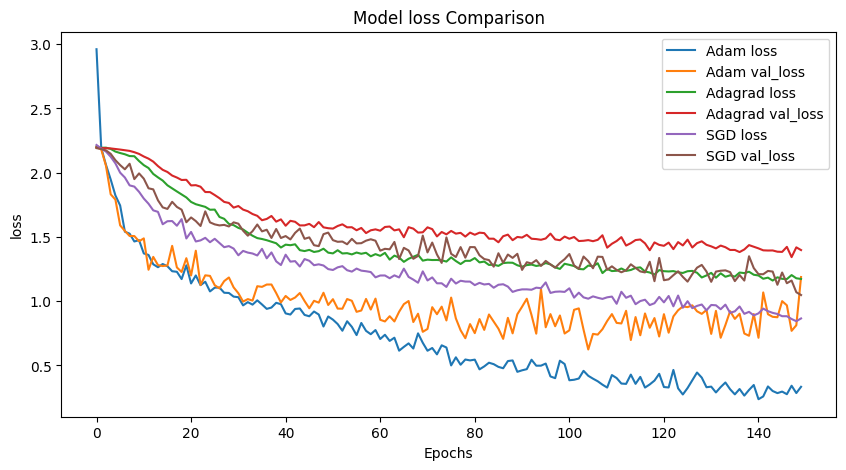

In [ ]:
def plot_history(histories, metric='accuracy'):
    plt.figure(figsize=(10, 5))

    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'{name} val_{metric}')

    plt.title(f'Model {metric} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_history(history, 'accuracy')
plot_history(history, 'loss')


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
def create_model():
  model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.5),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.5),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.5),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(9, activation='softmax')   # 9 kategori
  ])
  return model
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
# Kompilasi dan latih model dengan berbagai optimizer
optimizers = {
    'Adam': Adam(),
    'Adagrad': Adagrad(),
    'SGD': SGD()
}
history = {}

for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name} optimizer...")
    model = create_model()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history[opt_name] = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=100,
        # callbacks=reduce_lr,
        verbose=1
    )


Training with Adam optimizer...
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 898ms/step - accuracy: 0.1000 - loss: 4.9185 - val_accuracy: 0.1186 - val_loss: 2.1970
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 766ms/step - accuracy: 0.1255 - loss: 2.1968 - val_accuracy: 0.1186 - val_loss: 2.1972
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 617ms/step - accuracy: 0.1217 - loss: 2.1954 - val_accuracy: 0.1649 - val_loss: 2.1834
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 782ms/step - accuracy: 0.1445 - loss: 2.1549 - val_accuracy: 0.2113 - val_loss: 2.0427
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 617ms/step - accuracy: 0.2333 - loss: 2.0004 - val_accuracy: 0.2474 - val_loss: 2.0298
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 647ms/step - accuracy: 0.2321 - loss: 1.9321 - val_accuracy: 0.2938 - val_loss: 2.0230
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 608ms/step - accuracy: 0.2506 - loss: 1.9113 - val_accuracy: 0.3093 - val_loss: 1.9558
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - a

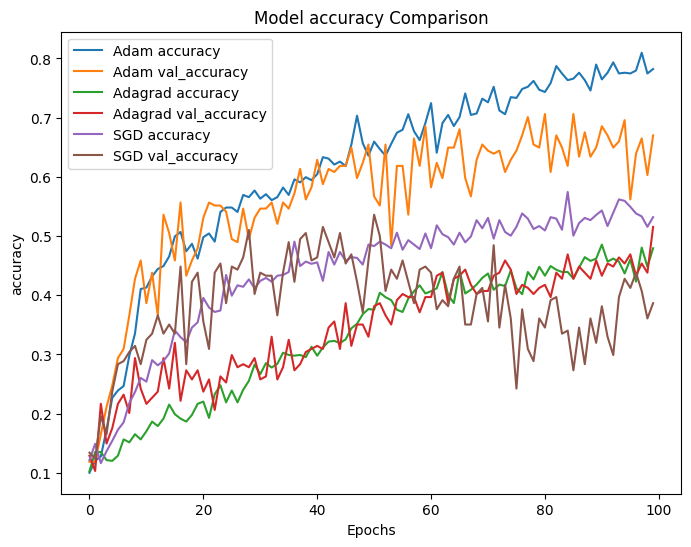

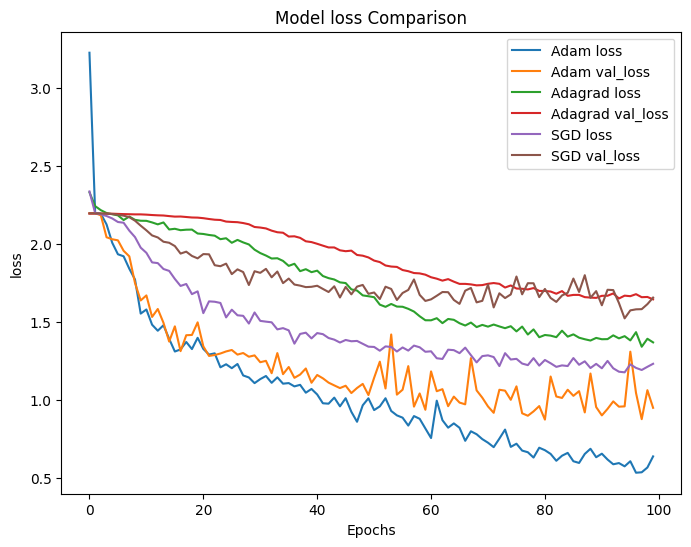

In [ ]:
def plot_history(histories, metric='accuracy'):
    plt.figure(figsize=(8, 6))

    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'{name} val_{metric}')

    plt.title(f'Model {metric} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_history(history, 'accuracy')
plot_history(history, 'loss')
#OTAKATIK PLOT NYA UKURANNYA

### NO DROPOUT

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
def create_model():
  model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(9, activation='softmax')   # 9 kategori
  ])
  return model
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
# Kompilasi dan latih model dengan berbagai optimizer
optimizers = {
    'Adam': Adam(),
    'Adagrad': Adagrad(),
    'SGD': SGD()
}
history = {}

for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name} optimizer...")
    model = create_model()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history[opt_name] = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=100,
        # callbacks=reduce_lr,
        verbose=1
    )


Training with Adam optimizer...
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 376s 11s/step - accuracy: 0.0976 - loss: 2.9734 - val_accuracy: 0.2526 - val_loss: 2.1303
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 732ms/step - accuracy: 0.2330 - loss: 2.0146 - val_accuracy: 0.2629 - val_loss: 1.8092
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 706ms/step - accuracy: 0.3521 - loss: 1.6369 - val_accuracy: 0.4021 - val_loss: 1.4831
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 689ms/step - accuracy: 0.4084 - loss: 1.5046 - val_accuracy: 0.3454 - val_loss: 1.6206
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 686ms/step - accuracy: 0.4321 - loss: 1.4690 - val_accuracy: 0.4278 - val_loss: 1.4633
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 672ms/step - accuracy: 0.4322 - loss: 1.4436 - val_accuracy: 0.4485 - val_loss: 1.4005
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 630ms/step - accuracy: 0.4654 - loss: 1.3764 - val_accuracy: 0.5464 - val_loss: 1.2805
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 669ms/step - ac

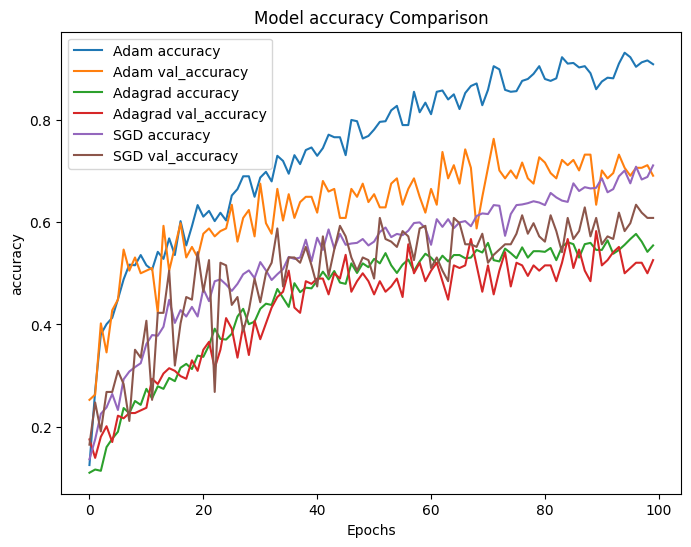

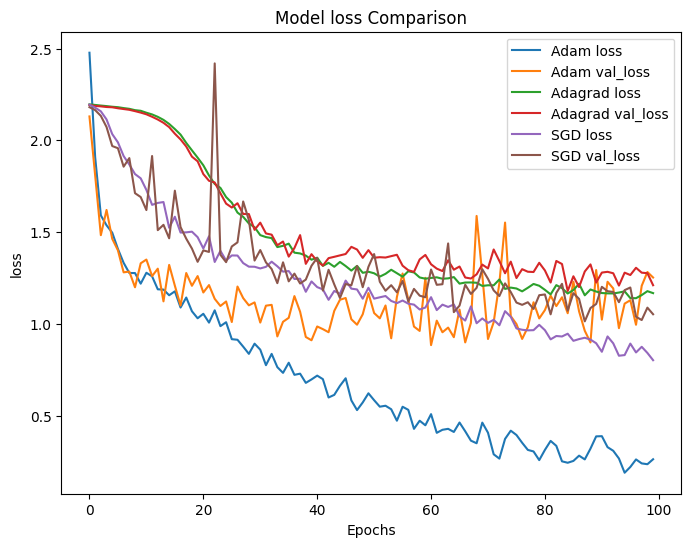

In [ ]:
def plot_history(histories, metric='accuracy'):
    plt.figure(figsize=(8, 6))

    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'{name} val_{metric}')

    plt.title(f'Model {metric} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_history(history, 'accuracy')
plot_history(history, 'loss')
#OTAKATIK PLOT NYA UKURANNYA

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
def create_model():
  model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(9, activation='softmax')   # 9 kategori
  ])
  return model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
# Kompilasi dan latih model dengan berbagai optimizer
optimizers = {
    'Adam': Adam(),
    'Adagrad': Adagrad(),
    'SGD': SGD()
}
history = {}

for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name} optimizer...")
    model = create_model()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history[opt_name] = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=100,
        callbacks=reduce_lr,
        verbose=1
    )



Training with Adam optimizer...
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.1238 - loss: 2.8358 - val_accuracy: 0.1186 - val_loss: 2.1960 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 611ms/step - accuracy: 0.1591 - loss: 2.1537 - val_accuracy: 0.2577 - val_loss: 1.9177 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 649ms/step - accuracy: 0.2426 - loss: 1.9269 - val_accuracy: 0.4227 - val_loss: 1.5418 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 606ms/step - accuracy: 0.4140 - loss: 1.5383 - val_accuracy: 0.4227 - val_loss: 1.5699 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 620ms/step - accuracy: 0.3568 - loss: 1.5778 - val_accuracy: 0.4175 - val_loss: 1.5299 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 606ms/step - accuracy: 0.3909 - loss: 1.4548 - val_accuracy: 0.4485 - val_loss: 1.4163 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 600

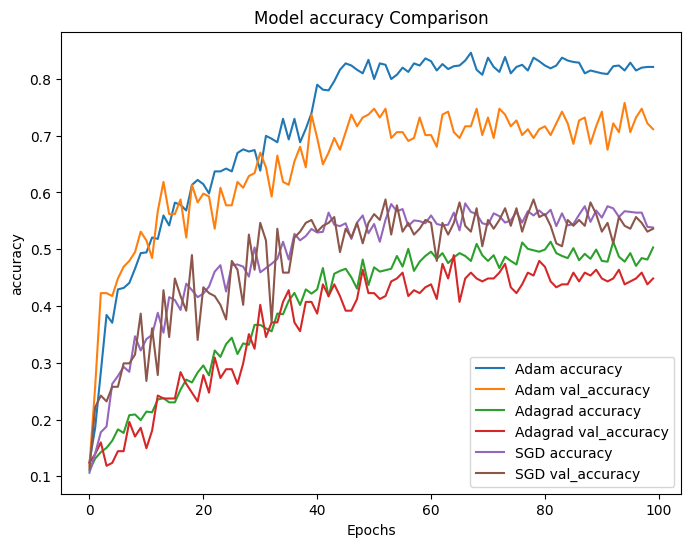

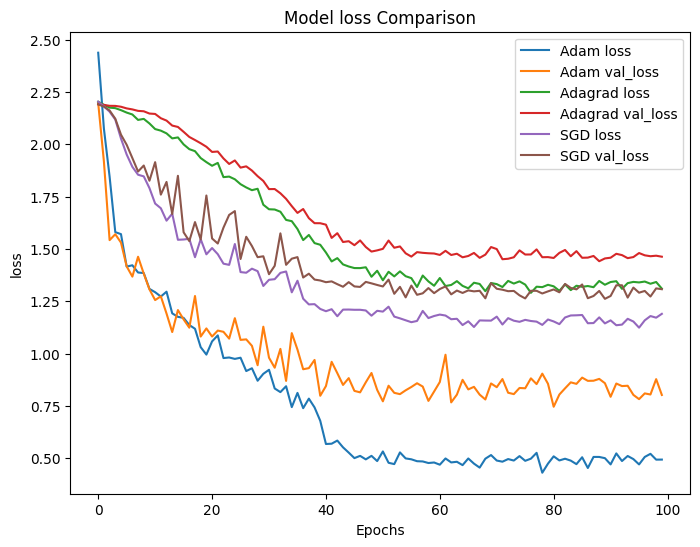

In [ ]:
def plot_history(histories, metric='accuracy'):
    plt.figure(figsize=(8, 6))

    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'{name} val_{metric}')

    plt.title(f'Model {metric} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_history(history, 'accuracy')
plot_history(history, 'loss')
#OTAKATIK PLOT NYA UKURANNYA

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
def create_model():
  model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(9, activation='softmax')   # 9 kategori
  ])
  return model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
# Kompilasi dan latih model dengan berbagai optimizer
optimizers = {
    'Adam': Adam(),
    'Adagrad': Adagrad(),
    'SGD': SGD()
}
history = {}

for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name} optimizer...")
    model = create_model()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history[opt_name] = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=100,
        callbacks=reduce_lr,
        verbose=1
    )


Training with Adam optimizer...
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 892ms/step - accuracy: 0.1409 - loss: 4.5901 - val_accuracy: 0.1443 - val_loss: 2.1498 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 620ms/step - accuracy: 0.2200 - loss: 2.0631 - val_accuracy: 0.2474 - val_loss: 1.9891 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 757ms/step - accuracy: 0.2359 - loss: 1.9925 - val_accuracy: 0.2990 - val_loss: 1.9457 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 709ms/step - accuracy: 0.2437 - loss: 1.9022 - val_accuracy: 0.2577 - val_loss: 1.8670 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 848ms/step - accuracy: 0.3195 - loss: 1.7795 - val_accuracy: 0.3763 - val_loss: 1.6957 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 604ms/step - accuracy: 0.3457 - loss: 1.6344 - val_accuracy: 0.4072 - val_loss: 1.6793 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 

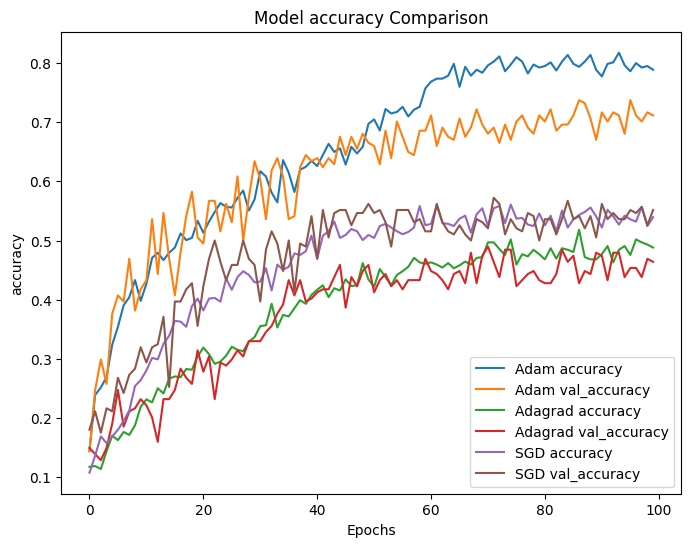

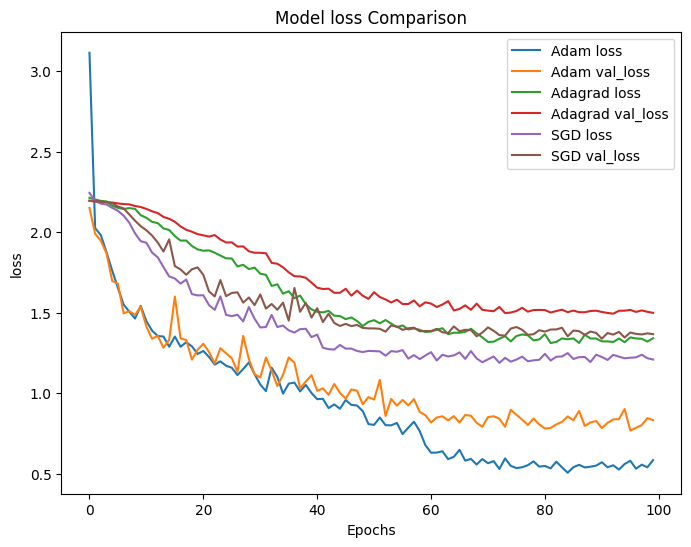

In [ ]:
def plot_history(histories, metric='accuracy'):
    plt.figure(figsize=(8, 6))

    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'{name} val_{metric}')

    plt.title(f'Model {metric} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_history(history, 'accuracy')
plot_history(history, 'loss')
#OTAKATIK PLOT NYA UKURANNYA

### BISMILLAH 0.90

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_model():
  model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(9, activation='softmax')   # 9 kategori
  ])
  return model
# reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=5, min_lr=1e-7)
# Kompilasi dan latih model dengan berbagai optimizer
optimizers = {
    'Adam': Adam(learning_rate=0.001),
    'Adagrad': Adagrad(),
    'SGD': SGD()
}
history = {}

for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name} optimizer...")
    model = create_model()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history[opt_name] = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=100,
        # callbacks=reduce_lr,
        verbose=1
    )


Training with Adam optimizer...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.0925 - loss: 3.1867 - val_accuracy: 0.2732 - val_loss: 2.1607
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 778ms/step - accuracy: 0.2497 - loss: 2.0004 - val_accuracy: 0.3660 - val_loss: 1.6664
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 682ms/step - accuracy: 0.3502 - loss: 1.6637 - val_accuracy: 0.3866 - val_loss: 1.6157
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 619ms/step - accuracy: 0.4176 - loss: 1.5145 - val_accuracy: 0.3608 - val_loss: 1.6423
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 619ms/step - accuracy: 0.3441 - loss: 1.5891 - val_accuracy: 0.4742 - val_loss: 1.4842
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 641ms/step - accuracy: 0.4530 - loss: 1.4308 - val_accuracy: 0.4433 - val_loss: 1.5888
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 615ms/step - accuracy: 0.3929 - loss: 1.4762 - val_accuracy: 0.4639 - val_loss: 1.4479
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 906ms/step - accuracy: 0.4877 - loss: 1.3293 - val_accuracy: 0

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_model():
  model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(9, activation='softmax')   # 9 kategori
  ])
  return model
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=10, min_lr=1e-7)
# Kompilasi dan latih model dengan berbagai optimizer
optimizers = {
    'Adam': Adam(learning_rate=0.001),
    'Adagrad': Adagrad(),
    'SGD': SGD()
}
history = {}

for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name} optimizer...")
    model = create_model()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history[opt_name] = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=100,
        callbacks=reduce_lr,
        verbose=1
    )


Training with Adam optimizer...
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 798ms/step - accuracy: 0.1207 - loss: 4.3159 - val_accuracy: 0.1186 - val_loss: 2.1971 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 706ms/step - accuracy: 0.0942 - loss: 2.1963 - val_accuracy: 0.1134 - val_loss: 2.1871 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 664ms/step - accuracy: 0.1316 - loss: 2.1848 - val_accuracy: 0.1186 - val_loss: 2.1965 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 694ms/step - accuracy: 0.1047 - loss: 2.1800 - val_accuracy: 0.1753 - val_loss: 2.0369 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 705ms/step - accuracy: 0.2603 - loss: 1.9165 - val_accuracy: 0.3144 - val_loss: 1.7959 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 678ms/step - accuracy: 0.3446 - loss: 1.6332 - val_accuracy: 0.4330 - val_loss: 1.5584 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 

KeyboardInterrupt: 

In [ ]:
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from datetime import datetime

def create_model():
  model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(9, activation='softmax')   # 9 kategori
  ])

  return model
# reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=10, min_lr=1e-7)
# Kompilasi dan latih model dengan berbagai optimizer
optimizers = {
    'Adam': Adam(),
    'Adagrad': Adagrad(),
    'SGD': SGD()
}
import os

# Direktori untuk menyimpan model
save_dir = '/content/drive/MyDrive/saved_models'
os.makedirs(save_dir, exist_ok=True)


history = {}

for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name} optimizer...")
    model = create_model()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history[opt_name] = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=100,
        # callbacks=reduce_lr,
        verbose=1
    )
    # Tambahkan timestamp ke nama file
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')  # Format: YYYYMMDD_HHMMSS
    model_save_path = os.path.join(save_dir, f'model_{opt_name}_{timestamp}.keras')
    model.save(model_save_path)
    print(f"Model saved as {model_save_path}")


Training with Adam optimizer...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.1299 - loss: 3.6821 - val_accuracy: 0.1443 - val_loss: 2.1895
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 496ms/step - accuracy: 0.1618 - loss: 2.1410 - val_accuracy: 0.2784 - val_loss: 2.0334
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 497ms/step - accuracy: 0.2185 - loss: 1.9563 - val_accuracy: 0.2577 - val_loss: 1.9460
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 501ms/step - accuracy: 0.2431 - loss: 1.8838 - val_accuracy: 0.2938 - val_loss: 1.8051
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 497ms/step - accuracy: 0.3364 - loss: 1.7952 - val_accuracy: 0.3608 - val_loss: 1.6074
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 496ms/step - accuracy: 0.3478 - loss: 1.5574 - val_accuracy: 0.4021 - val_loss: 1.6081
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 501ms/step - accuracy: 0.4305 - loss: 1.5057 - val_accuracy: 0.4072 - val_loss: 1.6279
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 495ms/step - accuracy: 0.4474 - loss: 1.4605 - val_accuracy: 0

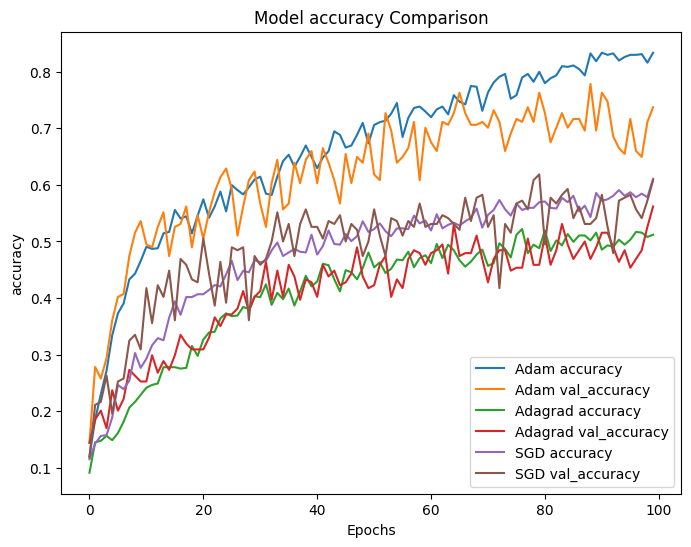

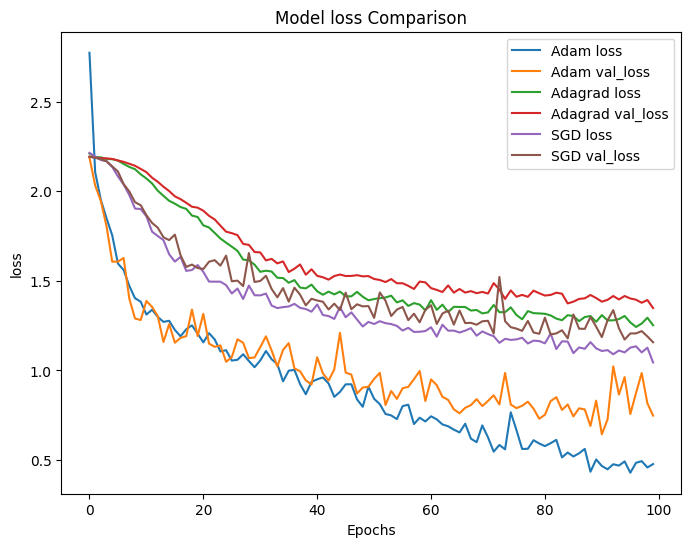

In [ ]:
def plot_history(histories, metric='accuracy'):
    plt.figure(figsize=(8, 6))

    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'{name} val_{metric}')

    plt.title(f'Model {metric} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_history(history, 'accuracy')
plot_history(history, 'loss')
#OTAKATIK PLOT NYA UKURANNYA

In [ ]:
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from datetime import datetime

def create_model():
  model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(9, activation='softmax')   # 9 kategori
  ])

  return model
# reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=10, min_lr=1e-7)
# Kompilasi dan latih model dengan berbagai optimizer
optimizers = {
    'Adam': Adam(),
    'Adagrad': Adagrad(),
    'SGD': SGD()
}
import os

# Direktori untuk menyimpan model
save_dir = '/content/drive/MyDrive/saved_models'
os.makedirs(save_dir, exist_ok=True)


history = {}

for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name} optimizer...")
    model = create_model()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history[opt_name] = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=100,
        # callbacks=reduce_lr,
        verbose=1
    )
    # Tambahkan timestamp ke nama file
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')  # Format: YYYYMMDD_HHMMSS
    model_save_path = os.path.join(save_dir, f'model_{opt_name}_{timestamp}.keras')
    model.save(model_save_path)
    print(f"Model saved as {model_save_path}")


Training with Adam optimizer...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 405s 13s/step - accuracy: 0.1082 - loss: 3.3812 - val_accuracy: 0.2010 - val_loss: 2.1806
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 494ms/step - accuracy: 0.1714 - loss: 2.1200 - val_accuracy: 0.3351 - val_loss: 1.7541
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 497ms/step - accuracy: 0.2870 - loss: 1.7829 - val_accuracy: 0.2938 - val_loss: 1.7154
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 507ms/step - accuracy: 0.3684 - loss: 1.5927 - val_accuracy: 0.3505 - val_loss: 1.7031
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 498ms/step - accuracy: 0.3627 - loss: 1.6635 - val_accuracy: 0.3969 - val_loss: 1.4930
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 500ms/step - accuracy: 0.4043 - loss: 1.4969 - val_accuracy: 0.3814 - val_loss: 1.6208
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 492ms/step - accuracy: 0.4251 - loss: 1.4975 - val_accuracy: 0.4639 - val_loss: 1.4839
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 503ms/step - accuracy: 0.4684 - loss: 1.3858 - val_accuracy:

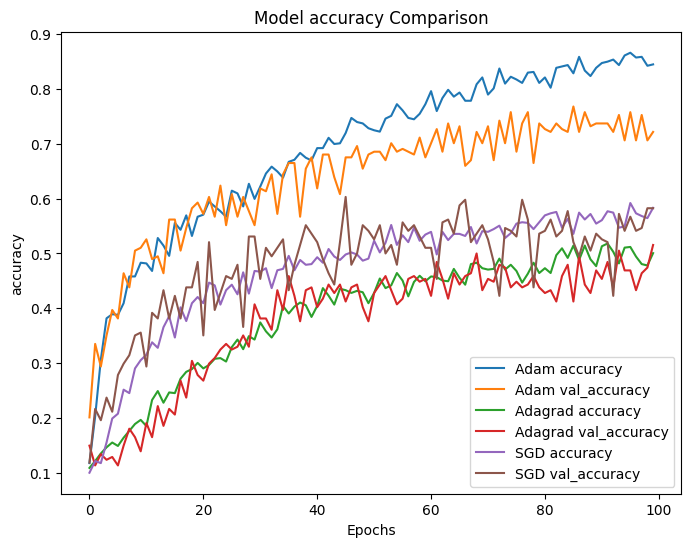

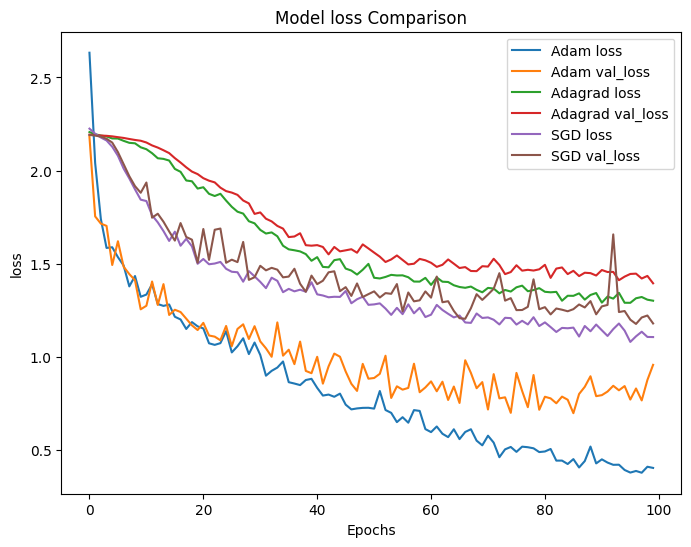

In [ ]:
def plot_history(histories, metric='accuracy'):
    plt.figure(figsize=(8, 6))

    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'{name} val_{metric}')

    plt.title(f'Model {metric} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_history(history, 'accuracy')
plot_history(history, 'loss')
#OTAKATIK PLOT NYA UKURANNYA

In [ ]:
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from datetime import datetime

def create_model():
  model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(9, activation='softmax')   # 9 kategori
  ])

  return model
# reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=10, min_lr=1e-7)
# Kompilasi dan latih model dengan berbagai optimizer
optimizers = {
    'Adam': Adam(),
    'Adagrad': Adagrad(),
    'SGD': SGD()
}
import os

# Direktori untuk menyimpan model
save_dir = '/content/drive/MyDrive/saved_models'
os.makedirs(save_dir, exist_ok=True)


history = {}

for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name} optimizer...")
    model = create_model()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history[opt_name] = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=100,
        # callbacks=reduce_lr,
        verbose=1
    )
    # Tambahkan timestamp ke nama file
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')  # Format: YYYYMMDD_HHMMSS
    model_save_path = os.path.join(save_dir, f'model_{opt_name}_{timestamp}.keras')
    model.save(model_save_path)
    print(f"Model saved as {model_save_path}")


Training with Adam optimizer...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 491s 14s/step - accuracy: 0.1038 - loss: 2.8207 - val_accuracy: 0.2577 - val_loss: 2.0269
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 507ms/step - accuracy: 0.2482 - loss: 1.9803 - val_accuracy: 0.3144 - val_loss: 1.8439
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 502ms/step - accuracy: 0.2614 - loss: 1.8865 - val_accuracy: 0.3505 - val_loss: 1.6451
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 508ms/step - accuracy: 0.3239 - loss: 1.6368 - val_accuracy: 0.3711 - val_loss: 1.6107
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 507ms/step - accuracy: 0.3637 - loss: 1.5891 - val_accuracy: 0.3505 - val_loss: 1.5905
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 500ms/step - accuracy: 0.3557 - loss: 1.5718 - val_accuracy: 0.4588 - val_loss: 1.4866
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 504ms/step - accuracy: 0.4279 - loss: 1.4325 - val_accuracy: 0.4691 - val_loss: 1.4177
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 503ms/step - accuracy: 0.3984 - loss: 1.4382 - val_accuracy:

KeyboardInterrupt: 

### Input Model Manual

Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


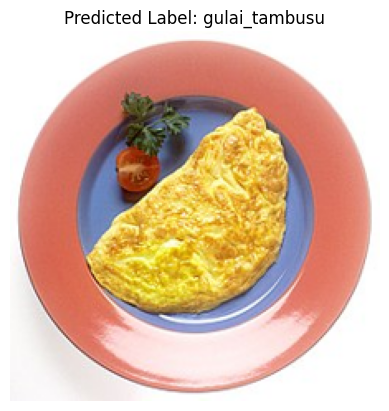

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Fungsi untuk memuat model CNN
def load_cnn_model(model_path):
    model = load_model(model_path)
    print("Model loaded successfully.")
    return model

# Fungsi untuk memproses gambar
def preprocess_image(image_path, target_size):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    image_array = np.array(image) / 255.0  # Normalisasi
    image_array = np.expand_dims(image_array, axis=0)  # Tambahkan dimensi batch
    return image_array, image

# Fungsi untuk memprediksi gambar
def predict_image(model, image_array, class_labels):
    prediction = model.predict(image_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = class_labels[predicted_class]
    return predicted_label

# Manual Input: Ganti dengan file model dan gambar Anda
model_path = "/content/drive/MyDrive/saved_models/model_Adam_20250119_131911.keras"  # Path ke file model Anda
image_path = "/content/drive/MyDrive/saved_models/telur_dadar.jpg"     # Path ke gambar Anda

# Daftar class/label (sesuaikan dengan dataset Anda)
class_labels = ['ayam_goreng', 'ayam_pop', 'daging_rendang', 'dendeng_batakok', 'gulai_ikan',
                'gulai_tambusu', 'gulai_tunjang', 'telur_balado', 'telur_dadar']

# Load model
model = load_cnn_model(model_path)

# Preprocess image
target_size = (224, 224)  # Sesuaikan dengan ukuran input model Anda
image_array, original_image = preprocess_image(image_path, target_size)

# Predict
predicted_label = predict_image(model, image_array, class_labels)

# Display the image and prediction
plt.imshow(original_image)
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_model():
  model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(9, activation='softmax')   # 9 kategori
  ])
  return model
# reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=10, min_lr=1e-7)
# Kompilasi dan latih model dengan berbagai optimizer
optimizers = {
    'Adam': Adam(),
    'Adagrad': Adagrad(),
    'SGD': SGD()
}
history = {}

for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name} optimizer...")
    model = create_model()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history[opt_name] = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=100,
        # callbacks=reduce_lr,
        verbose=1
    )


Training with Adam optimizer...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 259s 8s/step - accuracy: 0.0989 - loss: 4.8329 - val_accuracy: 0.1082 - val_loss: 2.1974
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 629ms/step - accuracy: 0.1089 - loss: 2.1974 - val_accuracy: 0.1134 - val_loss: 2.1972
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 614ms/step - accuracy: 0.1322 - loss: 2.1971 - val_accuracy: 0.1443 - val_loss: 2.1944
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 625ms/step - accuracy: 0.1340 - loss: 2.1824 - val_accuracy: 0.2113 - val_loss: 2.1226
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 641ms/step - accuracy: 0.2262 - loss: 2.0641 - val_accuracy: 0.2216 - val_loss: 1.9831
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 699ms/step - accuracy: 0.2650 - loss: 1.9333 - val_accuracy: 0.2423 - val_loss: 1.9324
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 696ms/step - accuracy: 0.2553 - loss: 1.9364 - val_accuracy: 0.2474 - val_loss: 1.9859
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 651ms/step - accuracy: 0.2363 - loss: 1.9862 - val_accuracy: 

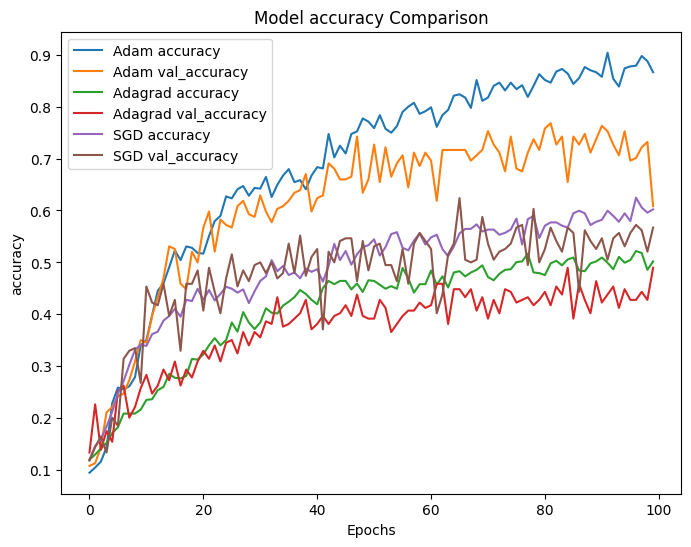

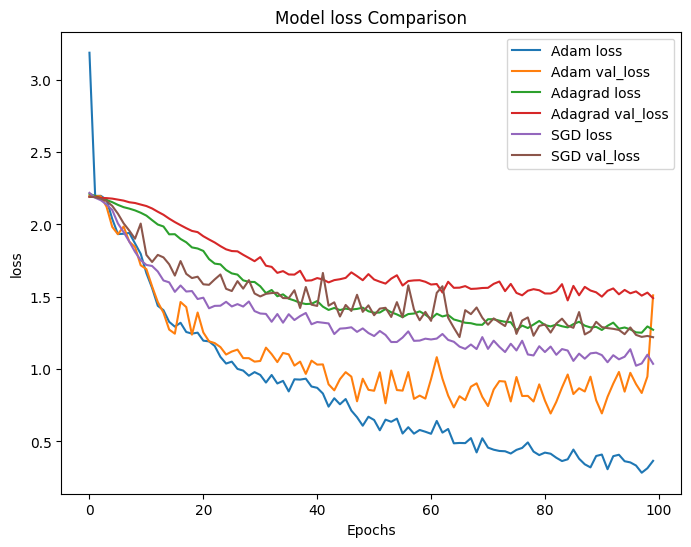

In [ ]:
def plot_history(histories, metric='accuracy'):
    plt.figure(figsize=(8, 6))

    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'{name} val_{metric}')

    plt.title(f'Model {metric} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_history(history, 'accuracy')
plot_history(history, 'loss')
#OTAKATIK PLOT NYA UKURANNYA

In [ ]:
# DATA TRAINING

#32, 64, 128, 256, 512, 512 stuck di 40an
#128, 64, 128, 256, 512, 512 stuck di 0.66 dan epochnya lama 150s
#32, 64, 128, 256, 512 stuck di 40an
#32, 64, 128, 256, 512 = 68s 3s/step - loss: 0.8588 - accuracy: 0.7196 - val_loss: 1.1052 - val_accuracy: 0.6082
#32, 64, 128, 256, 512, 1024 = Epoch 76/100 25/25 [==============================] - 73s 3s/step - loss: 1.7274 - accuracy: 0.4330 - val_loss: 2.0203 - val_accuracy: 0.3196

# 21.58 - 13.07.24 - 128, 256, 512, 1024 - DO 0,2 - 0,5
#Epoch 100: val_loss did not improve from 0.93597
#25/25 [==============================] - 14s 563ms/step - loss: 0.7673 - accuracy: 0.7635 - val_loss: 1.0444 - val_accuracy: 0.6495 - lr: 1.0000e-07

#09.59 - 14.07.24 - 128, 256, 512, ,1024 - DO 0,3 - 0,5
#Epoch 100: val_loss did not improve from 0.93597
#25/25 [==============================] - 14s 550ms/step - loss: 1.0675 - accuracy: 0.6258 - val_loss: 1.1270 - val_accuracy: 0.6237 - lr: 1.0000e-07

#11.29 - 14.07.24 - 128, 256, 512, ,1024 - DO 0,3 - 0,5
# Epoch 200: val_loss did not improve from 1.10780
# 25/25 [==============================] - 14s 556ms/step - loss: 1.0692 - accuracy: 0.6395 - val_loss: 1.2047 - val_accuracy: 0.6134 - lr: 1.0000e-07

#11.54 - 15.07.24 - 64, 128, 256, 512, ,1024 - DO 0,3 - 0,5
# Epoch 100/100
#25/25 [==============================] - 20s 783ms/step - loss: 1.1397 - accuracy: 0.6108 - val_loss: 1.2641 - val_accuracy: 0.5464 - lr: 1.0000e-07

#11.29 - 15.07.24 - 128, 128, 256, 512, ,1024, 512 - DO 0,5 - 0,5
# Epoch 100/100
#25/25 [==============================] - 20s 783ms/step - loss: 1.1397 - accuracy: 0.6108 - val_loss: 1.2641 - val_accuracy: 0.5464 - lr: 1.0000e-07

#16.03 - 16.07.24 - 64, 128, 256, 512, ,1024, 512 - DO 0,3 - 0,5 - R 0.01
# Epoch 100/100 - 8566

#14.23 - 17.07.24 - 64, 128, 256, 512, ,1024, ,512 - DO 0,5 - 0,5 - R 0.001
# Epoch 100/100 - akurasi stuck di 20-30

#15.11 - 17.07.24 - 64, 128, 256, 512, ,1024, ,256 - DO 0,3 - 0,5 - R 0.001
# Epoch 100/100 - akurasi stuck di 81-67

#16.11 - 17.07.24 - 64, 128, 256, 512, ,, ,256, 128 - DO 0,3 - 0,5 - R 0.1
# Epoch 93/150 - akurasi stuck di 75-67

#kalau neuron sebelum epochnya dikit, loss awalnya gede. kalau kebalikannya loss awalnya dikit

In [ ]:
# Membuat direktori untuk menyimpan model
checkpoint_dir = '/content/drive/My Drive/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Callback untuk menyimpan model
checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.h5'),
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get("accuracy") > 0.90 and logs.get("val_accuracy") > 0.90 ):
          print("\nReached accuracy > 0.90 so stopping the training!")
          self.model.stop_training = True

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Menggunakan ReduceLROnPlateau untuk menurunkan learning rate saat model berhenti membaik
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch= len(train_generator),#train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps= len(validation_generator), #validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    callbacks=[myCallback(), reduce_lr]
)


Epoch 1/150
25/25 [==============================] - 309s 12s/step - loss: 146.2545 - accuracy: 0.1777 - val_loss: 102.9286 - val_accuracy: 0.1134 - lr: 0.0010
Epoch 2/150
25/25 [==============================] - 15s 609ms/step - loss: 65.3408 - accuracy: 0.2904 - val_loss: 39.2455 - val_accuracy: 0.1134 - lr: 0.0010
Epoch 3/150
25/25 [==============================] - 15s 606ms/step - loss: 27.1379 - accuracy: 0.2954 - val_loss: 21.1117 - val_accuracy: 0.1186 - lr: 0.0010
Epoch 4/150
25/25 [==============================] - 16s 645ms/step - loss: 17.5059 - accuracy: 0.2916 - val_loss: 15.3752 - val_accuracy: 0.1134 - lr: 0.0010
Epoch 5/150
25/25 [==============================] - 17s 681ms/step - loss: 12.8751 - accuracy: 0.3542 - val_loss: 12.3834 - val_accuracy: 0.1186 - lr: 0.0010
Epoch 6/150
25/25 [==============================] - 15s 601ms/step - loss: 10.6730 - accuracy: 0.3592 - val_loss: 10.0998 - val_accuracy: 0.1186 - lr: 0.0010
Epoch 7/150
25/25 [==========================

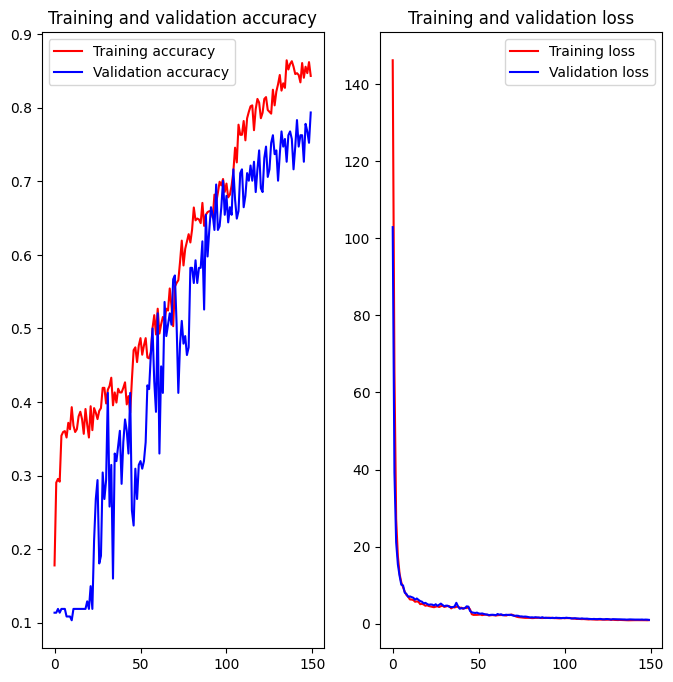

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
model.save('/content/drive/MyDrive/PDM/Model/model_padangfood8479.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### INPUT MANUAL MODEL

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from google.colab import files


In [ ]:
from tensorflow.keras.models import load_model

# Sesuaikan path ke lokasi model yang telah disimpan di Google Drive
model_path = '/content/drive/MyDrive/PDM/Model/model_padangfood8479.h5'
model = load_model(model_path)


In [ ]:
# Kelas kategori makanan padang
class_names = ['ayam_goreng', 'ayam_pop', 'daging_rendang', 'dendeng_batakok', 'gulai_ikan', 'gulai_tambusu', 'gulai_tunjang', 'telur_balado', 'telur_dadar']

def load_and_predict(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # Sesuaikan dengan ukuran input model
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f'Prediksi: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class


Saving dendeng_batokok (42).jpg to dendeng_batokok (42).jpg
Mengujikan gambar dendeng_batokok (42).jpg
1/1 [==============================] - 0s 17ms/step


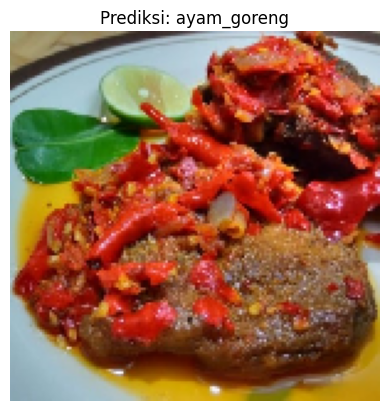

Prediksi: ayam_goreng


In [ ]:
# Unggah file gambar dari komputer Anda
uploaded = files.upload()

for file_name in uploaded.keys():
    print(f'Mengujikan gambar {file_name}')
    predicted_class = load_and_predict(file_name)
    print(f'Prediksi: {predicted_class}')


In [ ]:
# Memuat model dari checkpoint terakhir yang disimpan
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    model = load_model(latest_checkpoint)
    print(f'Model loaded from {latest_checkpoint}')
else:
    print('No checkpoint found, starting from scratch.')

NameError: name 'model' is not defined

In [ ]:
# Melanjutkan pelatihan
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=100,
    callbacks=[myCallback(), reduce_lr, checkpoint]
)
